# CompAIRR results analysis

We ran CompAIRR on the global dataset and we analyze the results in this notebook.

In [1]:
from itertools import combinations
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

import NegativeClassOptimization.config as config

In [2]:
compairr_path = Path("../data/CompAIRR")

## Overlaps

Text(0.5, 1.0, 'Allowed sequence-level difference = 2')

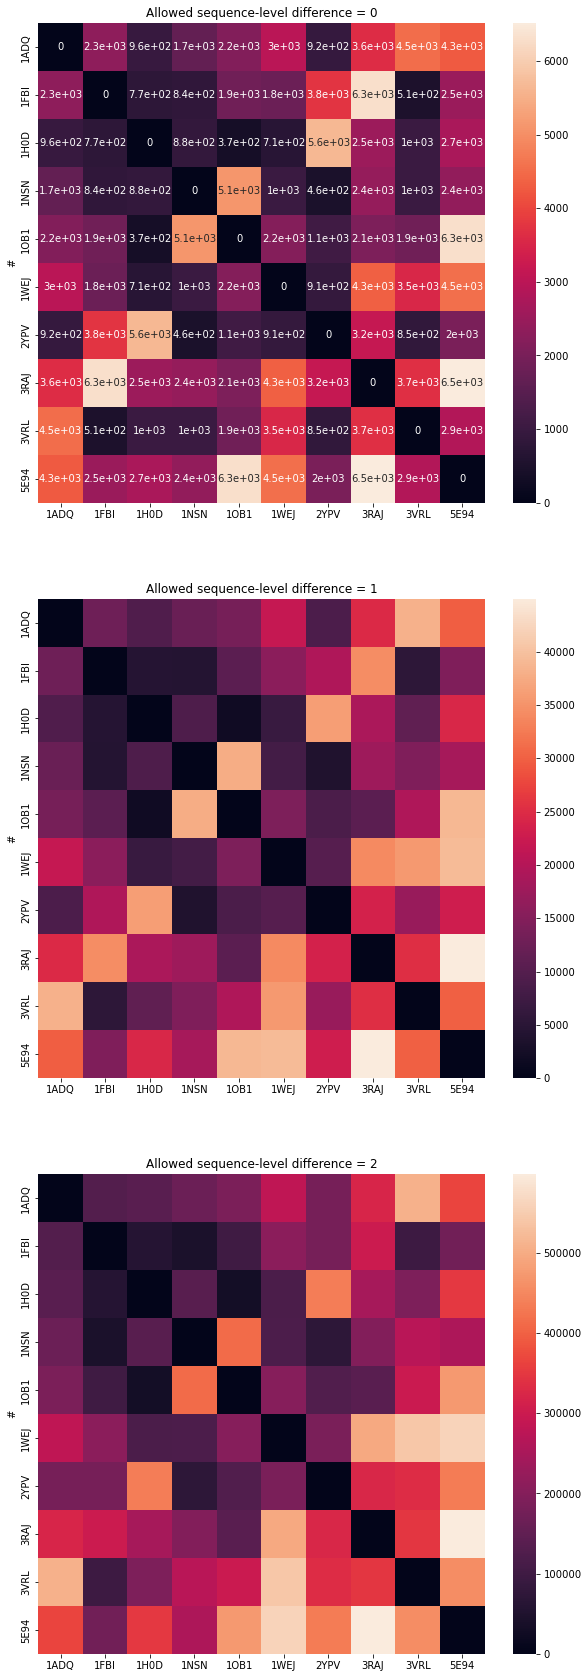

In [3]:
def get_overlaps(
    difference_th: int, 
    compairr_path = compairr_path,
    null_diagonal = True,
    ) -> pd.DataFrame:

    df_overlaps = pd.read_csv(
        compairr_path / f"overlaps_d{difference_th}_output.tsv", 
        sep='\t').set_index("#")
    
    if null_diagonal:
        for i in range(df_overlaps.shape[0]):
            df_overlaps.iloc[i, i] = 0
    
    return df_overlaps

df_overlaps_d0 = get_overlaps(0)
df_overlaps_d1 = get_overlaps(1)
df_overlaps_d2 = get_overlaps(2)

fig, axs = plt.subplots(nrows=3, figsize = (10, 30))
sns.heatmap(df_overlaps_d0, ax=axs[0], annot=True)
axs[0].set_title("Allowed sequence-level difference = 0")
sns.heatmap(df_overlaps_d1, ax=axs[1])
axs[1].set_title("Allowed sequence-level difference = 1")
sns.heatmap(df_overlaps_d2, ax=axs[2])
axs[2].set_title("Allowed sequence-level difference = 2")

<AxesSubplot:ylabel='#'>

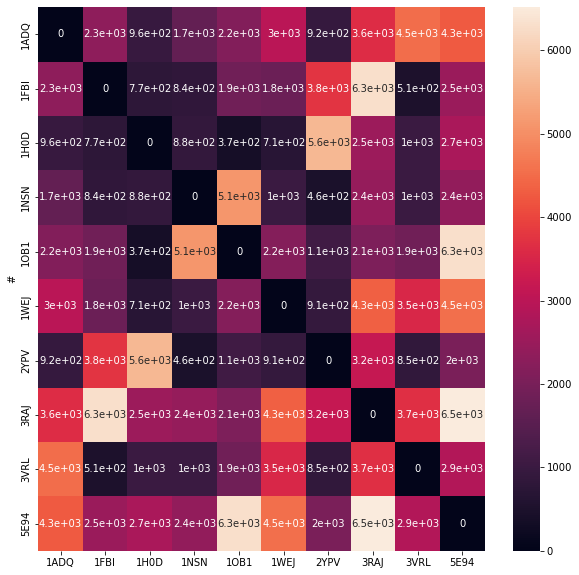

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_overlaps_d0, ax=ax, annot=True)

In [5]:
antigens = df_overlaps_d0.columns.to_list()
records = []
for (ag1, ag2) in combinations(antigens, r=2):
    records.append({
        "ag1_ag2": f"{ag1}_{ag2}",
        "d0_overlaps": np.log(df_overlaps_d0.loc[ag1, ag2]),
        "d1_overlaps": np.log(df_overlaps_d1.loc[ag1, ag2]),
        "d2_overlaps": np.log(df_overlaps_d2.loc[ag1, ag2]),
    })
df_pairs = pd.DataFrame.from_records(records)
df_pairs.head(2)

,ag1_ag2,d0_overlaps,d1_overlaps,d2_overlaps
0,1ADQ_1FBI,7.754910,9.457122,11.765938
1,1ADQ_1H0D,6.869014,9.141847,11.842215


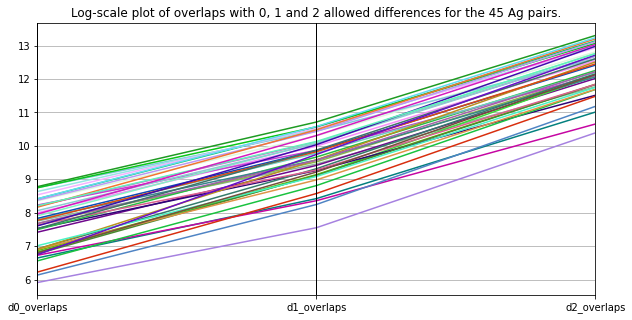

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.parallel_coordinates(df_pairs, class_column="ag1_ag2", ax=ax)
ax.set_title("Log-scale plot of overlaps with 0, 1 and 2 allowed differences for the 45 Ag pairs.")
ax.get_legend().remove()

## Clustering

First, let's evaluate the global clustering patterns.

In [7]:
def get_global_clustering_results(
    difference_th,
    compairr_path = compairr_path
    ) -> pd.DataFrame:
        
    df_c = pd.read_csv(compairr_path / f"clustering_d{difference_th}_output.tsv", sep='\t')
    df_c["Antigen"] = df_c["sequence_id"].str.split("_").str[0]
    df_c["cluster_id"] = df_c["#cluster_no"]
    return df_c

df_c1 = get_global_clustering_results(1)
df_c2 = get_global_clustering_results(2)
df_c1.head(3)

,#cluster_no,cluster_size,repertoire_id,sequence_id,duplicate_count,v_call,j_call,junction_aa,Antigen,cluster_id
0,1,271063,global,3VRL_1873658_06a,1,NaN,NaN,LLLLLWYFDVW,3VRL,1
1,1,271063,global,1NSN_7147788_05a,1,NaN,NaN,LLLLLWYFDVW,1NSN,1
2,1,271063,global,5E94_7116990_04a,1,NaN,NaN,LLLLLWYFDVW,5E94,1


In [8]:
def compute_cumulative_percentage(cluster_id_counts: pd.Series) -> pd.Series:
    sizes_cum = cluster_id_counts.cumsum()
    sizes_cum_perc = sizes_cum / cluster_id_counts.sum()
    return sizes_cum_perc

c1_sizes_cum_perc = compute_cumulative_percentage(df_c1["cluster_id"].value_counts())
c2_sizes_cum_perc = compute_cumulative_percentage(df_c2["cluster_id"].value_counts())

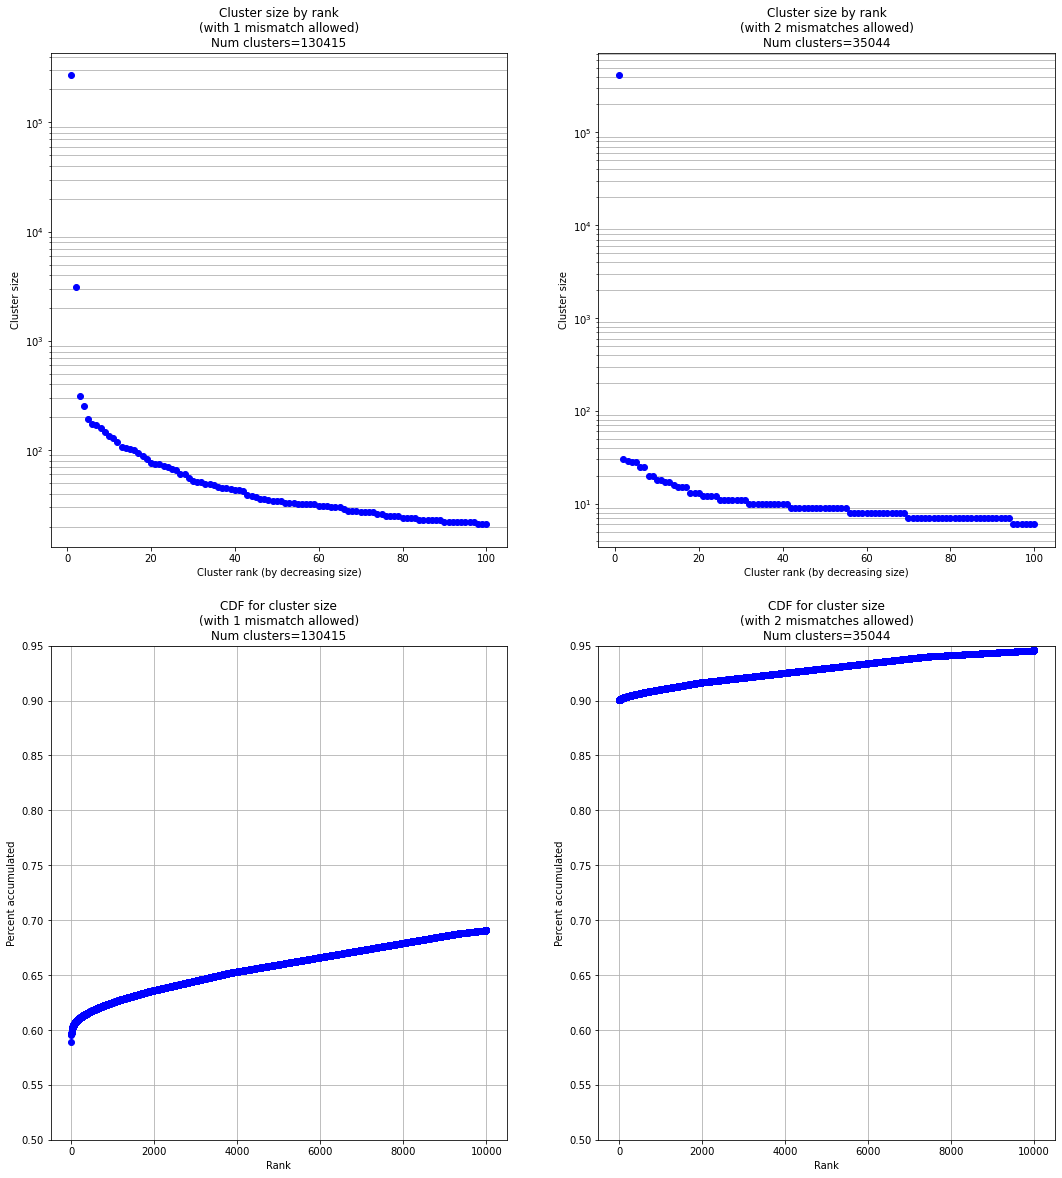

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 20), sharey=False, sharex=False)

N = 100
N_cum = 10000

axs[0][0].plot(
    range(1, N+1),
    df_c1["cluster_id"].value_counts().iloc[:N],
    "bo"
)
axs[0][1].plot(
    range(1, N+1),
    df_c2["cluster_id"].value_counts().iloc[:N],
    "bo"
)
axs[1][0].plot(
    range(1, N_cum+1),
    c1_sizes_cum_perc.iloc[:N_cum],
    "bo"
)
axs[1][1].plot(
    range(1, N_cum+1),
    c2_sizes_cum_perc.iloc[:N_cum],
    "bo"
)

axs[0][0].set_title(f"Cluster size by rank\n(with 1 mismatch allowed)\nNum clusters={df_c1['cluster_id'].unique().shape[0]}")
axs[0][1].set_title(f"Cluster size by rank\n(with 2 mismatches allowed)\nNum clusters={df_c2['cluster_id'].unique().shape[0]}")

for ax in axs[0]:
    ax.set_xlabel("Cluster rank (by decreasing size)")
    ax.set_ylabel("Cluster size")
    ax.set_yscale("log")
    ax.grid(which="minor")

axs[1][0].set_title(f"CDF for cluster size\n(with 1 mismatch allowed)\nNum clusters={df_c1['cluster_id'].unique().shape[0]}")
axs[1][1].set_title(f"CDF for cluster size\n(with 2 mismatches allowed)\nNum clusters={df_c2['cluster_id'].unique().shape[0]}")

for ax in axs[1]:
    ax.set_xlabel("Rank")
    ax.set_ylabel("Percent accumulated")
    ax.set_ylim((0.5, 0.95))
    ax.grid()

Check largest cluster composition.

In [10]:
vc = df_c1.groupby("cluster_id")["Antigen"].value_counts()
df_vc = pd.DataFrame(vc).rename(columns={"Antigen": "counts"})
df_vc = df_vc.reset_index().set_index("cluster_id")
df_vc = df_vc.pivot(columns="Antigen").fillna(1e-10)
df_vc.columns = df_vc.columns.droplevel(0)
df_vc.columns.name = None
df_vc_perc = df_vc.apply(lambda col_array: col_array / df_vc.sum(axis=1))

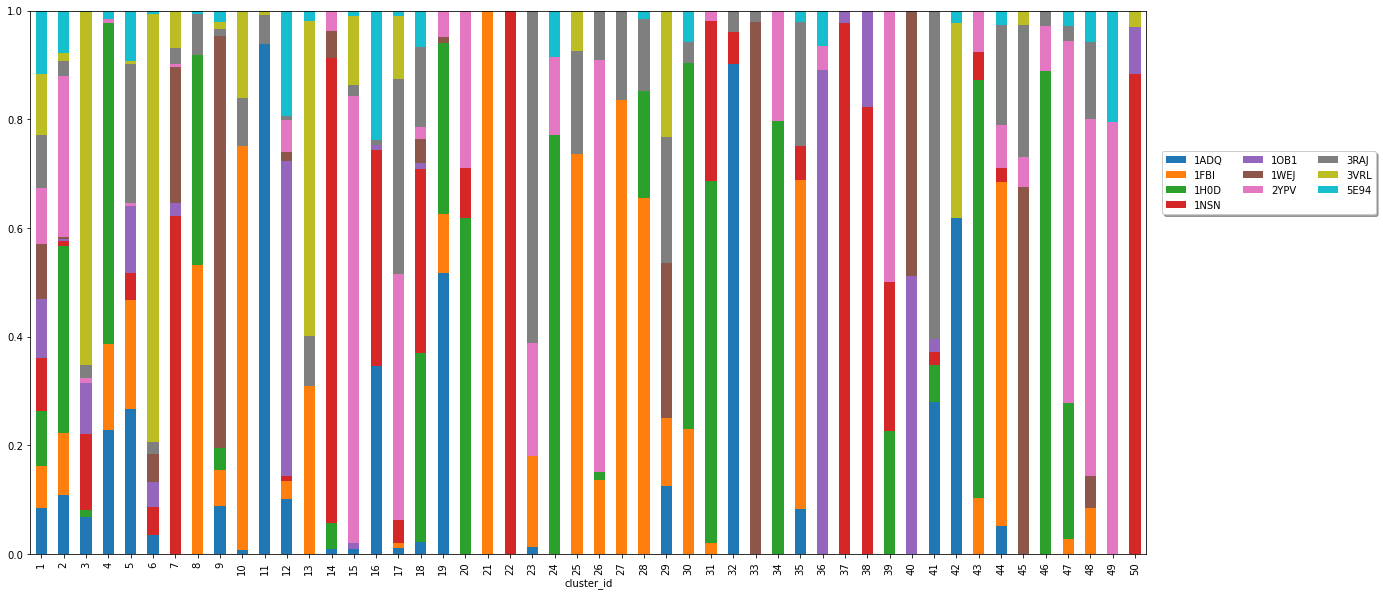

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
df_vc_perc.iloc[:50].plot.bar(stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.01, 0.75),
            ncol=3, fancybox=True, shadow=True)

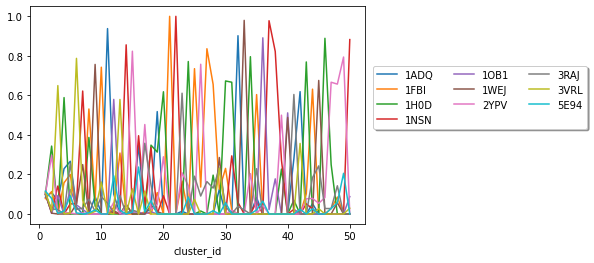

In [12]:
df_vc_perc.iloc[:50].plot.line()
plt.legend(bbox_to_anchor=(1.01, 0.75),
            ncol=3, fancybox=True, shadow=True)

Network analysis of the large cluster. For d1, the largest cluster's size is ~270k, with ~213k (~80%) unique sequences.

It's unfeasible for a first run to perform the analysis on such a big network. I'll let it run in parallel, meanwhile will do sampling.

In [71]:
c1_seqs = df_c1.loc[df_c1["cluster_id"] == 1]["junction_aa"].unique().tolist()
c1_seqs_sample = np.random.choice(c1_seqs, size=10000, replace=False)

In [72]:
G = nx.Graph()
G.add_nodes_from(c1_seqs_sample)

for i, (seq1, seq2) in enumerate(combinations(c1_seqs_sample, 2)):
    mismatches = 0
    for j in range(11):
        if seq1[j] != seq2[j]:
            mismatches += 1
    if mismatches <= 1:
        G.add_edge(seq1, seq2)

First check num edges and connected components.

In [73]:
num_edges = G.size()
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {num_edges}")

ccs = nx.connected_components(G)
ccs = list(sorted(ccs, key = lambda x: -len(x)))
print(f"Number of connected components: {len(ccs)}")
print(f"Sizes of largest 20 connected components: {list(map(len, ccs[:20]))}")

degrees = [d for n, d in G.degree()]
degrees = sorted(degrees, key = lambda x: -x)
print(f"Top 20 degrees: {degrees[:10]}")

Number of nodes: 10000
Number of edges: 1680
Number of connected components: 8420
Sizes of largest 20 connected components: [28, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6]
Top 20 degrees: [9, 6, 5, 5, 4, 4, 4, 4, 4, 4]


Let's draw the largest connected components.

Text(0.5, 0.98, 'CDR3-Slide similarity network - largest 9 connected components (from a 10k sample of largest cluster)')

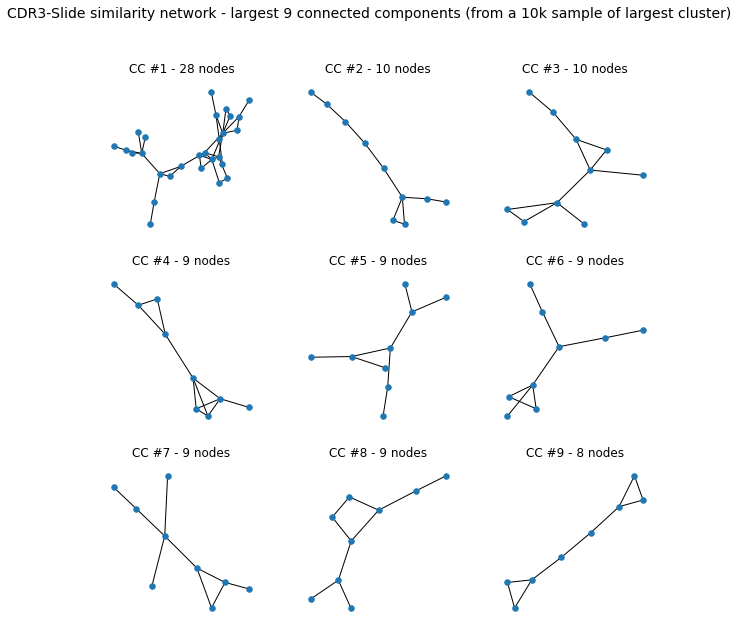

In [78]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        cc_id = i*3 + j
        nx.draw(G.subgraph(ccs[cc_id]), ax=ax, node_size=30)
        ax.set_title(f"CC #{cc_id + 1} - {len(ccs[cc_id])} nodes")

fig.suptitle('CDR3-Slide similarity network - largest 9 connected components (from a 10k sample of largest cluster)', fontsize=14)